# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


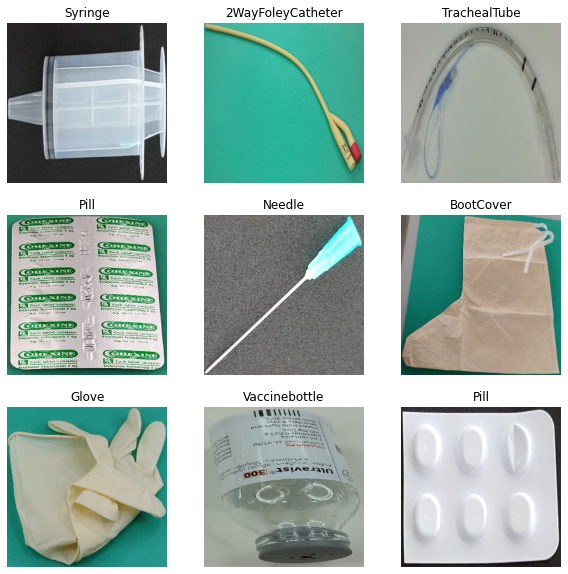

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 21,852,361
Non-trainable params: 34,432
_________________________________________________________________


In [20]:
EPOCHS = 1000
save_model_interval = 10
checkpoint_filepath = 'D:/ModelMedicalWasteCheckpoint/Incepv3_OurOutputLayer-NoClassImbalanced/OurOutputLayer-NoClassImbalanced-epoch{epoch:03d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.000001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/1000
49/49 [==============================] - 75s 744ms/step - loss: 1.2025 - accuracy: 0.6743 - val_loss: 70.1320 - val_accuracy: 0.0686
Epoch 2/1000
49/49 [==============================] - 26s 541ms/step - loss: 0.3860 - accuracy: 0.8814 - val_loss: 4.2930 - val_accuracy: 0.2975
Epoch 3/1000
49/49 [==============================] - 26s 541ms/step - loss: 0.2084 - accuracy: 0.9389 - val_loss: 2.8823 - val_accuracy: 0.3997
Epoch 4/1000
49/49 [==============================] - 27s 542ms/step - loss: 0.2035 - accuracy: 0.9380 - val_loss: 2.4496 - val_accuracy: 0.4787
Epoch 5/1000
49/49 [==============================] - 27s 542ms/step - loss: 0.1545 - accuracy: 0.9496 - val_loss: 2.1702 - val_accuracy: 0.6041
Epoch 6/1000
49/49 [==============================] - 27s 541ms/step - loss: 0.0891 - accuracy: 0.9716 - val_loss: 6.9023 - val_accuracy: 0.3545
Epoch 7/1000
49/49 [==============================] - 27s 542ms/step - loss: 0.0891 - accuracy: 0.9729 - val_loss: 2.7663 - val_a

Text(0.5, 1.0, 'Training and Validation Accuracy')

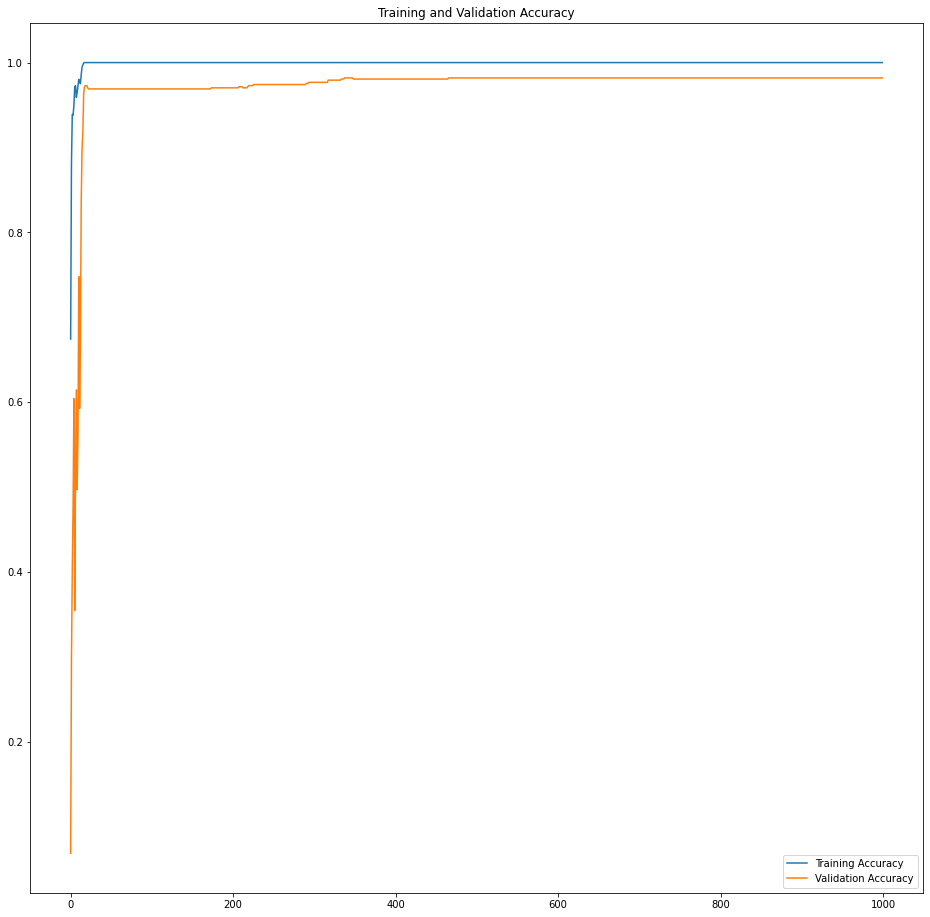

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


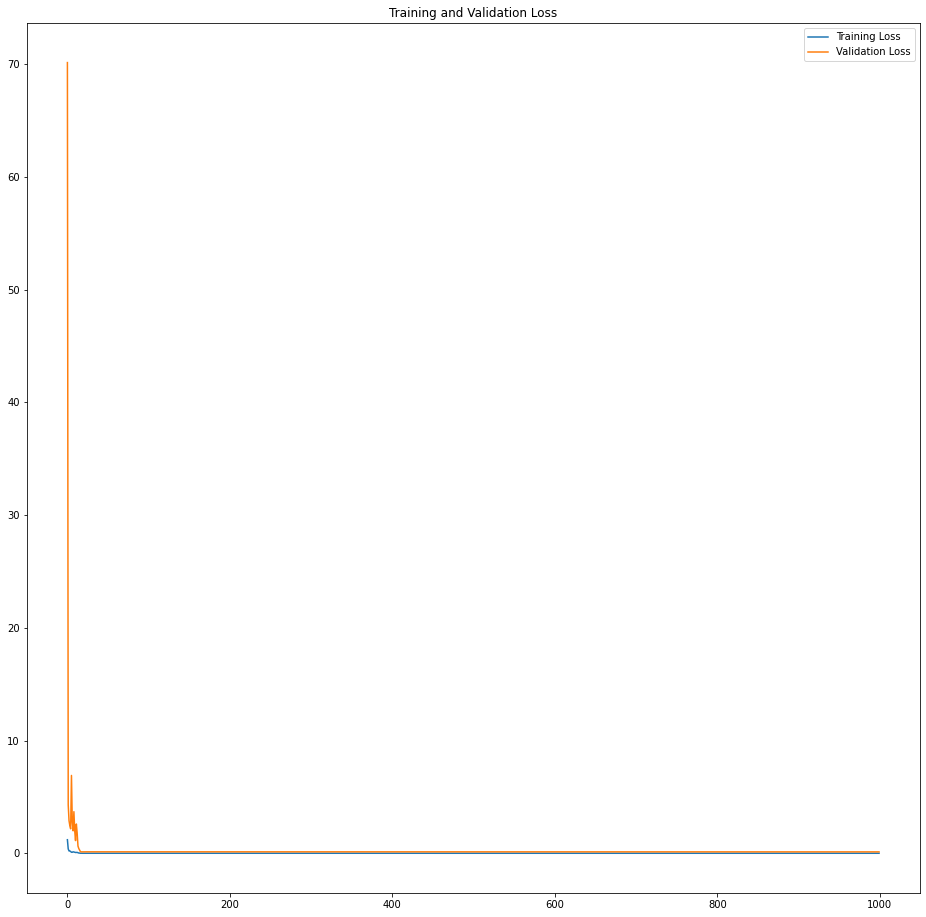

In [22]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 343ms/step - loss: 3.4449 - accuracy: 0.5435
test_indoor_ds_results:test loss, test acc: [3.4448907375335693, 0.54347825050354]


In [24]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 460ms/step - loss: 3.6093 - accuracy: 0.5990
test_outdoor_ds_results:test loss, test acc: [3.609272003173828, 0.5990445613861084]


In [25]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 195ms/step - loss: 1.1091 - accuracy: 0.8015
test_belt_ds_results:test loss, test acc: [1.1090714931488037, 0.8014506101608276]


In [26]:
# Read path of trained model
import os, os.path
trained_path = 'D:/ModelMedicalWasteCheckpoint/Incepv3_OurOutputLayer-NoClassImbalanced/'
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced/OurOutputLayer-NoClassImbalanced-epoch010-val_acc0.56.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced/OurOutputLayer-NoClassImbalanced-epoch020-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced/OurOutputLayer-NoClassImbalanced-epoch030-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced/OurOutputLayer-NoClassImbalanced-epoch040-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced/OurOutputLayer-NoClassImbalanced-epoch050-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced/OurOutputLayer-NoClassImbalanced-epoch060-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced/OurOutputLayer-NoClassImbalanced-epoch070-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/OurOutputLayer-NoClassImbalanced/OurOutputLayer-NoClassImbalanced-epoch080-val_acc0.97.pb',


In [27]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 132ms/step - loss: 4.0416 - accuracy: 0.3196
Epoch010 
 test_indoor_acc=0.2028985470533371 
 test_outdoor_acc=0.24777069687843323 
 test_belt_acc=0.3195829689502716
35/35 [==============================] - 5s 132ms/step - loss: 1.1105 - accuracy: 0.7724
Epoch020 
 test_indoor_acc=0.48383501172065735 
 test_outdoor_acc=0.5624203681945801 
 test_belt_acc=0.7724388241767883
35/35 [==============================] - 5s 133ms/step - loss: 1.0852 - accuracy: 0.7806
Epoch030 
 test_indoor_acc=0.4972129464149475 
 test_outdoor_acc=0.5633757710456848 
 test_belt_acc=0.7805983424186707
35/35 [==============================] - 5s 131ms/step - loss: 1.0856 - accuracy: 0.7806
Epoch040 
 test_indoor_acc=0.4972129464149475 
 test_outdoor_acc=0.5636942386627197 
 test_belt_acc=0.7805983424186707
35/35 [==============================] - 5s 131ms/step - loss: 1.0856 - accuracy: 0.7806
Epoch050 
 test_indoor_acc=0.4972129464149475 
 test_outdoor_acc=0.5636942386

range(10, 1010, 10)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

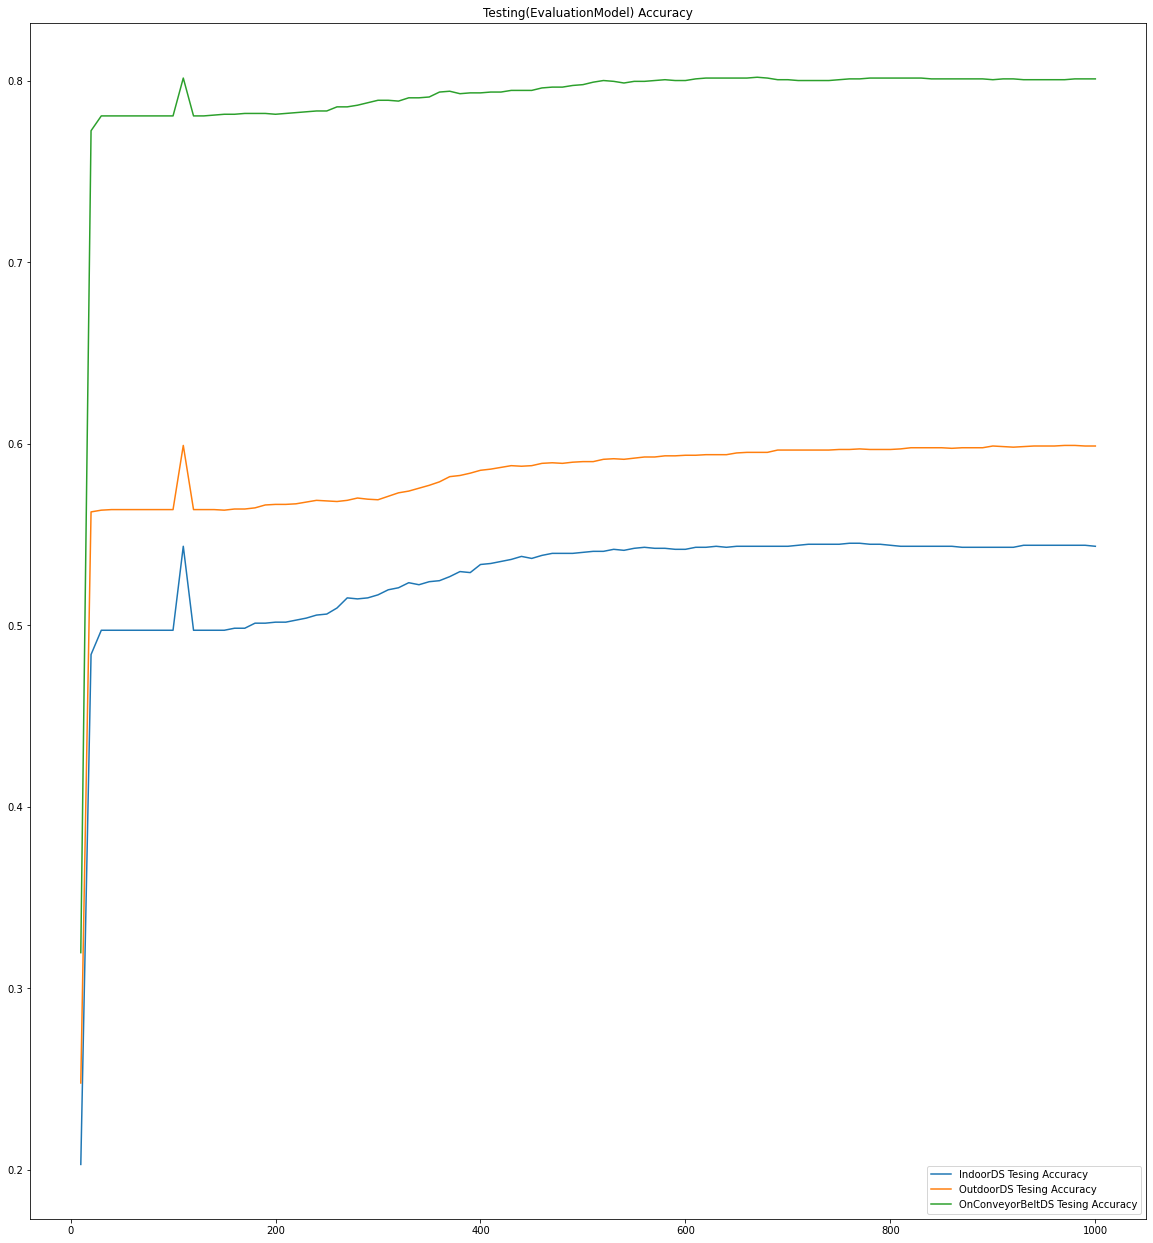

In [28]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

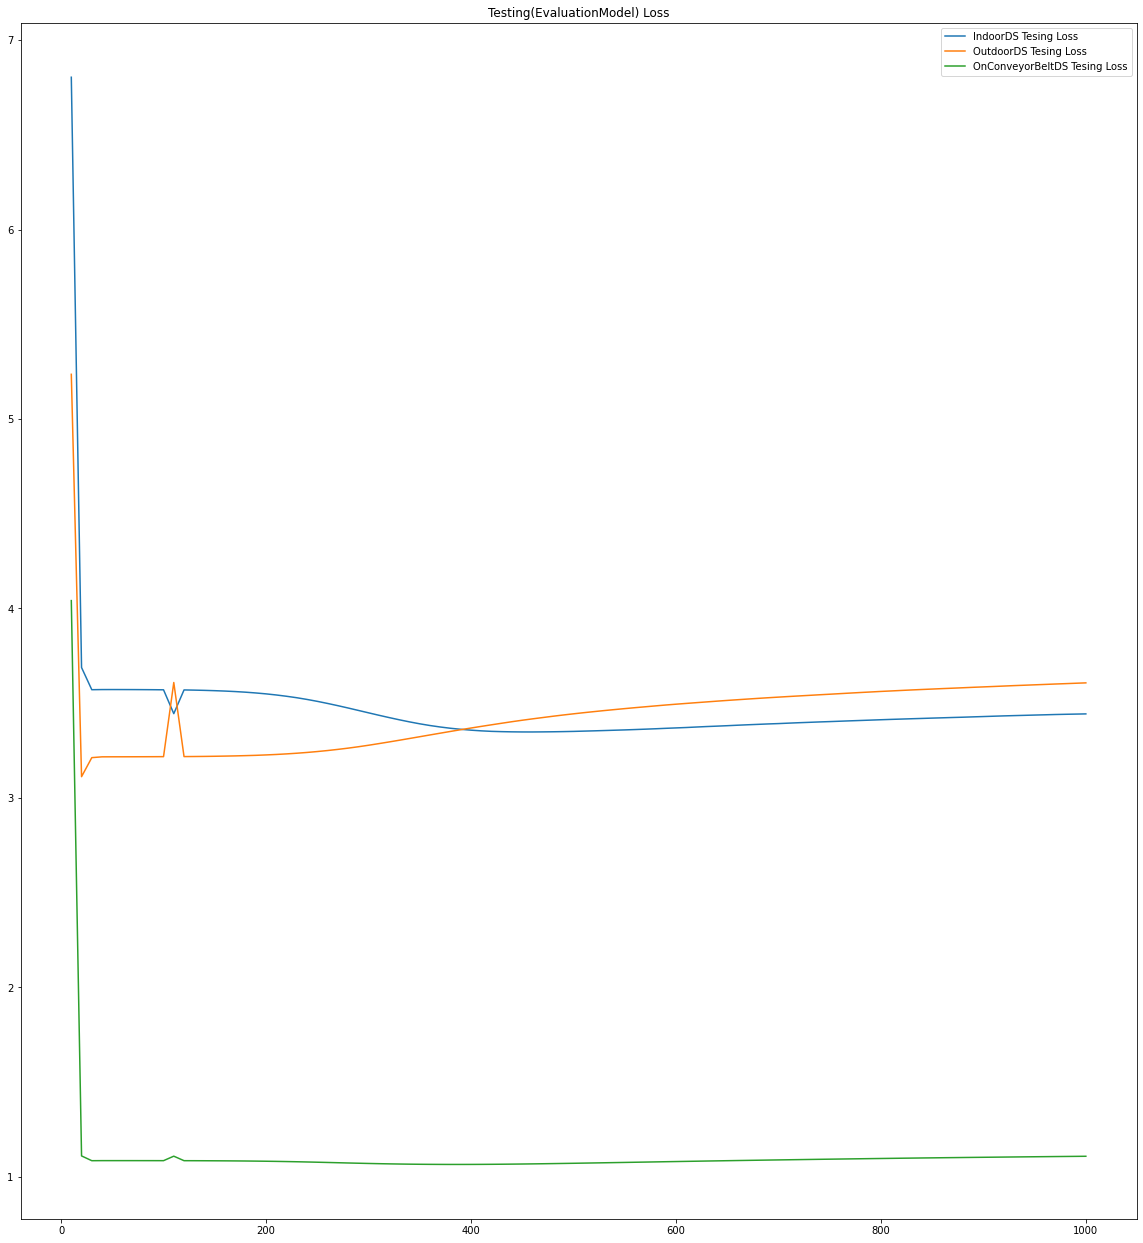

In [29]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [30]:
test_indoor_acc

[0.2028985470533371,
 0.48383501172065735,
 0.4972129464149475,
 0.4972129464149475,
 0.4972129464149475,
 0.4972129464149475,
 0.4972129464149475,
 0.4972129464149475,
 0.4972129464149475,
 0.4972129464149475,
 0.54347825050354,
 0.4972129464149475,
 0.4972129464149475,
 0.4972129464149475,
 0.4972129464149475,
 0.49832776188850403,
 0.49832776188850403,
 0.5011148452758789,
 0.5011148452758789,
 0.5016722679138184,
 0.5016722679138184,
 0.5027870535850525,
 0.5039018988609314,
 0.505574107170105,
 0.5061315298080444,
 0.5094760060310364,
 0.5150501728057861,
 0.5144927501678467,
 0.5150501728057861,
 0.5167223811149597,
 0.519509494304657,
 0.5206242799758911,
 0.5234113931655884,
 0.5222965478897095,
 0.5239687561988831,
 0.5245261788368225,
 0.5267558693885803,
 0.5295429229736328,
 0.5289855003356934,
 0.5334448218345642,
 0.5340022444725037,
 0.5351170301437378,
 0.5362318754196167,
 0.5379041433334351,
 0.5367892980575562,
 0.5384615659713745,
 0.5395763516426086,
 0.53957635164

In [31]:
test_outdoor_acc

[0.24777069687843323,
 0.5624203681945801,
 0.5633757710456848,
 0.5636942386627197,
 0.5636942386627197,
 0.5636942386627197,
 0.5636942386627197,
 0.5636942386627197,
 0.5636942386627197,
 0.5636942386627197,
 0.5990445613861084,
 0.5636942386627197,
 0.5636942386627197,
 0.5636942386627197,
 0.5633757710456848,
 0.5640127658843994,
 0.5640127658843994,
 0.5646497011184692,
 0.5662420392036438,
 0.5665605068206787,
 0.5665605068206787,
 0.5668789744377136,
 0.5678343772888184,
 0.5687897801399231,
 0.5684713125228882,
 0.5681528449058533,
 0.5687897801399231,
 0.5700637102127075,
 0.5694267749786377,
 0.5691083073616028,
 0.5710191130638123,
 0.5729299187660217,
 0.5738853216171265,
 0.5754777193069458,
 0.5770700573921204,
 0.5789808630943298,
 0.5818471312522888,
 0.5824840664863586,
 0.5837579369544983,
 0.5853503346443176,
 0.5859872698783875,
 0.5869426727294922,
 0.5878980755805969,
 0.587579607963562,
 0.5878980755805969,
 0.5891719460487366,
 0.5894904732704163,
 0.5891719460

In [32]:
test_belt_acc

[0.3195829689502716,
 0.7724388241767883,
 0.7805983424186707,
 0.7805983424186707,
 0.7805983424186707,
 0.7805983424186707,
 0.7805983424186707,
 0.7805983424186707,
 0.7805983424186707,
 0.7805983424186707,
 0.8014506101608276,
 0.7805983424186707,
 0.7805983424186707,
 0.7810516953468323,
 0.7815049886703491,
 0.7815049886703491,
 0.781958281993866,
 0.781958281993866,
 0.781958281993866,
 0.7815049886703491,
 0.781958281993866,
 0.7824115753173828,
 0.7828649282455444,
 0.7833182215690613,
 0.7833182215690613,
 0.7855847477912903,
 0.7855847477912903,
 0.7864913940429688,
 0.7878513336181641,
 0.7892112135887146,
 0.7892112135887146,
 0.7887579202651978,
 0.7905711531639099,
 0.7905711531639099,
 0.7910245060920715,
 0.7937443256378174,
 0.7941976189613342,
 0.7928377389907837,
 0.7932910323143005,
 0.7932910323143005,
 0.7937443256378174,
 0.7937443256378174,
 0.7946509718894958,
 0.7946509718894958,
 0.7946509718894958,
 0.7960108518600464,
 0.796464204788208,
 0.796464204788208

In [33]:
test_indoor_loss

[6.804067134857178,
 3.6882638931274414,
 3.571234703063965,
 3.572007894515991,
 3.572103500366211,
 3.5720162391662598,
 3.5718841552734375,
 3.5716142654418945,
 3.571263313293457,
 3.570741891860962,
 3.4448907375335693,
 3.570058822631836,
 3.569086790084839,
 3.567800760269165,
 3.5661346912384033,
 3.564053773880005,
 3.5614356994628906,
 3.5581722259521484,
 3.554119825363159,
 3.5492944717407227,
 3.543466329574585,
 3.5366437435150146,
 3.52892804145813,
 3.5198981761932373,
 3.5098917484283447,
 3.4988269805908203,
 3.4871225357055664,
 3.4748213291168213,
 3.4620747566223145,
 3.4492909908294678,
 3.4365735054016113,
 3.424329996109009,
 3.4125173091888428,
 3.401460886001587,
 3.3912644386291504,
 3.382220983505249,
 3.3744349479675293,
 3.367758274078369,
 3.362306833267212,
 3.3577048778533936,
 3.3541100025177,
 3.3514370918273926,
 3.349891424179077,
 3.34885835647583,
 3.3482913970947266,
 3.348207712173462,
 3.3486406803131104,
 3.349224805831909,
 3.3500795364379883

In [34]:
test_outdoor_loss

[5.236050128936768,
 3.1122124195098877,
 3.2126853466033936,
 3.216909408569336,
 3.217111587524414,
 3.2171900272369385,
 3.217297315597534,
 3.2174699306488037,
 3.2176589965820312,
 3.2179203033447266,
 3.609272003173828,
 3.2182483673095703,
 3.2186496257781982,
 3.2191903591156006,
 3.2199268341064453,
 3.2208423614501953,
 3.221895217895508,
 3.2233035564422607,
 3.224846601486206,
 3.2270045280456543,
 3.229454517364502,
 3.2324681282043457,
 3.235969305038452,
 3.2400617599487305,
 3.244835615158081,
 3.250155448913574,
 3.256188154220581,
 3.26275372505188,
 3.2700960636138916,
 3.2780466079711914,
 3.2866311073303223,
 3.2954399585723877,
 3.3044676780700684,
 3.3137576580047607,
 3.323106527328491,
 3.3324828147888184,
 3.341789484024048,
 3.3510289192199707,
 3.360185146331787,
 3.3689873218536377,
 3.3776204586029053,
 3.386014223098755,
 3.3942625522613525,
 3.4024205207824707,
 3.4100828170776367,
 3.417356491088867,
 3.4242916107177734,
 3.4311859607696533,
 3.43776130

In [35]:
test_belt_loss

[4.041594505310059,
 1.1104758977890015,
 1.085203766822815,
 1.0855517387390137,
 1.0855835676193237,
 1.0855737924575806,
 1.0855576992034912,
 1.0855286121368408,
 1.0854709148406982,
 1.0853995084762573,
 1.1090714931488037,
 1.085301399230957,
 1.0851471424102783,
 1.0849679708480835,
 1.0847234725952148,
 1.0844334363937378,
 1.0840510129928589,
 1.0836070775985718,
 1.0830341577529907,
 1.082357406616211,
 1.0815790891647339,
 1.0806576013565063,
 1.0796372890472412,
 1.0784605741500854,
 1.0772143602371216,
 1.0758869647979736,
 1.0745347738265991,
 1.0731674432754517,
 1.0718913078308105,
 1.0706346035003662,
 1.0695079565048218,
 1.0685139894485474,
 1.0676417350769043,
 1.0669032335281372,
 1.0663508176803589,
 1.0659257173538208,
 1.0656386613845825,
 1.065464735031128,
 1.0654704570770264,
 1.0655767917633057,
 1.06583833694458,
 1.0661728382110596,
 1.0666182041168213,
 1.067150592803955,
 1.0677300691604614,
 1.0683956146240234,
 1.069133996963501,
 1.069913387298584,
 1

## Load Last Epoch and test in each class

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model('D:\ModelMedicalWasteCheckpoint\Incepv3_OurOutputLayer-NoClassImbalanced-NoAug\OurOutputLayer-NoClassImbalanced-NoAug-epoch430-val_acc0.99.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [ ]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=4782
FP=2358
acc=0.6697478991596638
all check = 7140


In [ ]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')

1WayConnectorforFoley acc = 56.03448275862068%
2WayConnectorforFoley acc = 71.42857142857143%
2WayFoleyCatheter acc = 50.0%
3WayConnectorforFoley acc = 87.17948717948718%
3Waystopcock acc = 99.09909909909909%
AlcoholBottle acc = 81.875%
AlcoholPad acc = 34.92063492063492%
BootCover acc = 58.43373493975904%
CottonBall acc = 92.81437125748504%
CottonSwap acc = 50.349650349650354%
Dilator acc = 63.24786324786324%
DisposableInfusionSet acc = 38.93805309734513%
ExtensionTube acc = 33.33333333333333%
FaceShield acc = 67.28395061728395%
FrontLoadSyringe acc = 13.274336283185843%
GauzePad acc = 68.18181818181817%
Glove acc = 69.94047619047619%
GuideWire acc = 31.25%
LiquidBottle acc = 67.93893129770993%
Mask acc = 84.15584415584415%
NGTube acc = 34.193548387096776%
NasalCannula acc = 46.902654867256636%
Needle acc = 86.78571428571429%
OxygenMask acc = 46.616541353383454%
PPESuit acc = 88.70967741935483%
PharmaceuticalProduct acc = 70.32710280373831%
Pill acc = 98.0392156862745%
PillBottle acc 

In [ ]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

In [ ]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

In [ ]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

In [ ]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")